In [1]:
# Mengimport Library Yang di gunakan
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.size'] = 8
import tensorflow as tf

import warnings
warnings.simplefilter('ignore')

In [2]:
# Mengatur Path dari dataset
PATH_DATASET = '../input/ct-kidney-dataset-normal-cyst-tumor-and-stone'

In [3]:
# Image generator yang digunakan untuk training (termasuk augmentation)
imgTrainGen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 45,
    zoom_range = 0.2,
    shear_range = 0.2,
    featurewise_center = True,
    featurewise_std_normalization = True,
    width_shift_range = 0,
    height_shift_range = 0,
    vertical_flip = False,
    validation_split = 0.4,
    fill_mode = 'nearest'
)
# Image generator untuk testing 
imgTestGen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.4
)

# M generator with flow from directory
# Build for training
trainGeneratorBuild = imgTrainGen.flow_from_directory(
    PATH_DATASET,
    subset = 'training',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32
)
# Build for test
testGeneratorBuild = imgTestGen.flow_from_directory(
    PATH_DATASET,
    subset = 'validation',
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 32, shuffle=False
)

Found 7468 images belonging to 1 classes.
Found 4978 images belonging to 1 classes.


In [4]:
class_weight={
    'COVID': 1.463,
    'Lung_Opacity': 0.88,
    'Normal': 0.519,
    'Viral Pneumonia': 3.93
}


# 3. Create the Model

In [5]:
# Import the mobilenet pretrained base
'''''pretrained_base = tf.keras.applications.efficientnet.EfficientNetB6(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(224, 224, 3), pooling=None, classes=1000,
    classifier_activation='softmax'
) '''''
pretrained_base = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(224, 224, 3), alpha=1.0, include_top=False, weights='imagenet',
    input_tensor=None, pooling=None, classes=1000,
    classifier_activation='softmax'
) 


# Freeze the pretrained base
pretrained_base.trainable = True;

model = tf.keras.Sequential([
    pretrained_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'), # This is our head
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])
model.summary()

# Create our model

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 2,422,468
Trainable params: 2,388,356
Non-trainable params: 34,112
_________________________________________________________________


In [6]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss='categorical_crossentropy',
    metrics='accuracy'
)


# Proses training 30 epoch

start = datetime.datetime.now()
history = model.fit(trainGeneratorBuild,
                    epochs = 30, 
                    validation_data = testGeneratorBuild,
                    workers = 8, 
                    verbose = 1)

end = datetime.datetime.now()
print(f'Total Training Time: {end - start}')

Epoch 1/30
234/234 [==============================] - 167s 656ms/step - loss: 334.3670 - accuracy: 0.1402 - val_loss: 17.0599 - val_accuracy: 0.0000e+00
Epoch 2/30
234/234 [==============================] - 156s 650ms/step - loss: 2531.4182 - accuracy: 0.1311 - val_loss: 541.7856 - val_accuracy: 0.0000e+00
Epoch 3/30
234/234 [==============================] - 157s 660ms/step - loss: 5639.1303 - accuracy: 0.1409 - val_loss: 1046.3411 - val_accuracy: 0.0000e+00
Epoch 4/30
234/234 [==============================] - 155s 648ms/step - loss: 8118.0760 - accuracy: 0.1411 - val_loss: 1137.7733 - val_accuracy: 0.0000e+00
Epoch 5/30
234/234 [==============================] - 155s 646ms/step - loss: 10489.7188 - accuracy: 0.1493 - val_loss: 1123.1647 - val_accuracy: 0.0000e+00
Epoch 6/30
234/234 [==============================] - 155s 646ms/step - loss: 12508.4990 - accuracy: 0.1542 - val_loss: 2050.9138 - val_accuracy: 0.0000e+00
Epoch 7/30
234/234 [==============================] - 153s 640ms/s

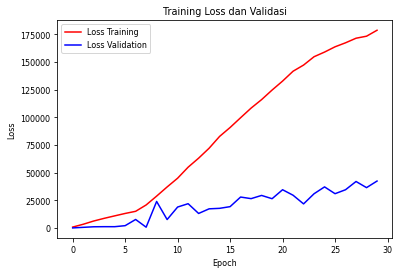

In [7]:
# Plotting training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], 'r', label='Loss Training')
plt.plot(history.history['val_loss'], 'b', label='Loss Validation')
plt.title('Training Loss dan Validasi')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

In [8]:
# Save the history as dataframe
history_df = pd.DataFrame(history.history)
history_df.to_csv('history.csv')

In [9]:
loss, acc = model.evaluate(trainGeneratorBuild)
val_loss, val_acc = model.evaluate(testGeneratorBuild)
loss, acc = model.evaluate(testGeneratorBuild)


156/156 [==============================] - 39s 251ms/step - loss: 42388.5273 - accuracy: 0.0000e+00


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


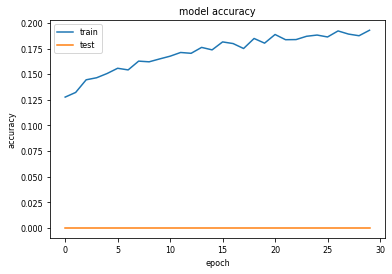

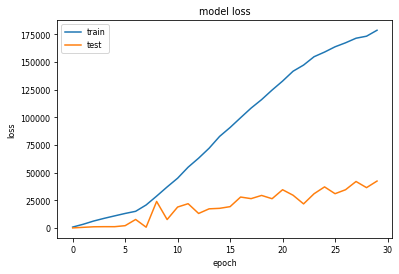

In [10]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [11]:
import numpy as np
from sklearn.utils.multiclass import unique_labels
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.utils import to_categorical
import random


In [12]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
name = 'DenseNet_Pneumonia'
with open(name+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(name+".h5")
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv(name+'.csv',index = False)
hist_df.tail()


,loss,accuracy,val_loss,val_accuracy
25,163786.625000,0.186261,30963.441406,0.0
26,167401.750000,0.192153,34545.039062,0.0
27,171542.109375,0.189073,41990.289062,0.0
28,173368.968750,0.187467,36445.722656,0.0
29,178754.500000,0.192823,42388.527344,0.0


In [13]:
json_file = open('./'+name+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./"+name+".h5")
print("Loaded model from disk")


Loaded model from disk


In [14]:
history_1= history


In [15]:
def ModelGraphTrainngSummary(history,N,model_name):
    # set the matplotlib backend so figures can be saved in the background
    # plot the training loss and accuracy
    import sys
    import matplotlib
    print("Generating plots...")
    sys.stdout.flush()
    matplotlib.use("Agg")
    matplotlib.pyplot.style.use("ggplot")
    matplotlib.pyplot.figure()
    matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["acc"], label="train_acc")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
    matplotlib.pyplot.title("Training Loss and Accuracy on Brain Tumor Classification")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Loss/Accuracy of "+model_name)
    matplotlib.pyplot.legend(loc="lower left")
    matplotlib.pyplot.savefig("plot.png")


In [16]:
def ModelGraphTrainngSummaryAcc(history,N,model_name):
    # set the matplotlib backend so figures can be saved in the background
    # plot the training loss and accuracy
    import sys
    import matplotlib
    print("Generating plots...")
    sys.stdout.flush()
    matplotlib.use("Agg")
    matplotlib.pyplot.style.use("ggplot")
    matplotlib.pyplot.figure()
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    #matplotlib.pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["acc"], label="train_acc")
    matplotlib.pyplot.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
    matplotlib.pyplot.title("Training Loss and Accuracy")
    matplotlib.pyplot.xlabel("Epoch #")
    matplotlib.pyplot.ylabel("Accuracy of "+ model_name)
    matplotlib.pyplot.legend(loc="lower left")
    matplotlib.pyplot.savefig("plot.png")


In [17]:
from sklearn.metrics import classification_report


In [18]:
preds = model.predict(testGeneratorBuild)

preds_list = []

for pred in preds:
  preds_list.append(np.argmax(pred))

report = classification_report(testGeneratorBuild.classes, preds_list)


In [19]:
print(report)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    4978.0
           3       0.00      0.00      0.00       0.0

    accuracy                           0.00    4978.0
   macro avg       0.00      0.00      0.00    4978.0
weighted avg       0.00      0.00      0.00    4978.0



In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
import seaborn as sns
